In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [3]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.attack.naturalness import AdvContentLoss
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates
# from adv_manhole.texture_mapping.mapping import mapped_texture_mask, depth_texture_mapping

The console stream is logged into /home/carla_client/sg_logs/console.log


[2024-05-31 08:19:28] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


## Load Dataset

In [4]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

In [5]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config"]
)
print(filtered_columns_dataset)

In [6]:
data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
        },
        remove_columns=["raw_depth", "camera_config"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

data_iterable

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f39a3fe97c0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f39a47b86d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f39a47b8b80>}

## Load Target Model

In [7]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})
DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 532
    })
})


/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-05-31 08:19:49] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

## Content Loss initialization

In [8]:
imsize = 224  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to("cuda", torch.float)

In [9]:
manhole_candidate_path = "/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/manhole"

# Load the candidate images
candidate_images = []
for filename in os.listdir(manhole_candidate_path):
    candidate_img = image_loader(f"{manhole_candidate_path}/{filename}")
    candidate_images.append(candidate_img)

candidate_images = torch.cat(candidate_images, dim=0)
print(candidate_images.shape)

torch.Size([9, 3, 224, 224])


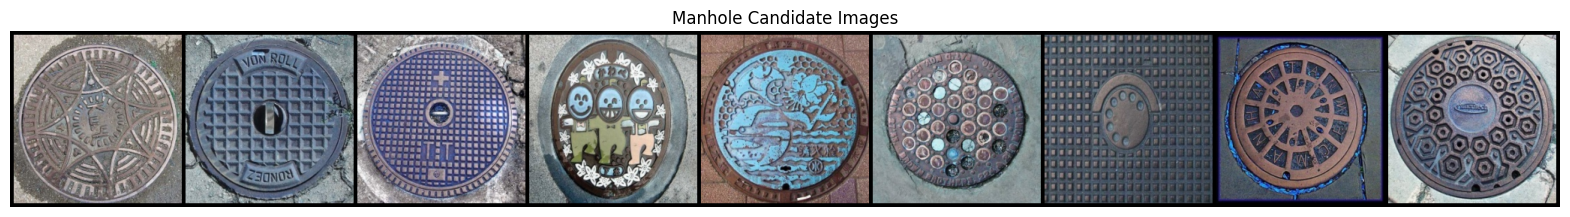

In [10]:
# Plot the candidate images in a grid format
plt.figure(figsize=(20, 5))
plt.imshow(
    np.transpose(
        make_grid(candidate_images, nrow=10, padding=5).cpu(),
        (1, 2, 0),
    )
)
plt.title("Manhole Candidate Images")
plt.axis("off")
plt.show()

In [11]:
adv_content_loss = AdvContentLoss(
    candidate_images=candidate_images,
)

/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/adv_manhole/attack/naturalness.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/adv_manhole/attack/naturalness.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [12]:
adv_content_loss.candidate_features.shape

torch.Size([9, 1605632])

In [13]:
# def mapped_texture_mask(
#     surface_xyz,
#     tex_size=1.0,
#     tex_shift=[0.0, 0.0, 0.0],
# ):

#     x_offset = tex_shift[0]
#     y_offset = tex_shift[1]

#     # Mask the centerized local coordinates given the texture size
#     texture_mask = torch.where(
#         (surface_xyz[0, ...] > x_offset)
#         & (surface_xyz[0, ...] < x_offset + tex_size)
#         & (surface_xyz[1, ...] > y_offset)
#         & (surface_xyz[1, ...] < y_offset + tex_size),
#         1.0,
#         0.0,
#     )

#     return texture_mask


# def depth_texture_mapping(
#     texture,
#     surface_xyz,
#     tex_size=1.0,
#     tex_shift=[0.0, 0.0, 0.0],
#     texture_res=256,
# ):
#     # Convert to channel last
#     surface_xyz = surface_xyz.permute(1, 2, 0)
#     # normal_mask = normal_mask.permute(1, 2, 0)
#     texture_flat = texture.permute(1, 2, 0).view(-1, 3)
#     max_uv_idx = texture_res**2 - 1

#     # Get the UV coordinates by modulating the surface coordinates with the texture size
#     surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
#     surface_xyz_mod = surface_xyz_mod / tex_size

#     # Get the UV indices by multiplying the UV coordinates with the texture resolution
#     uv_idx = surface_xyz_mod * texture_res
#     uv_idx = torch.round(uv_idx).to(torch.int64)
#     uv_idx = torch.clamp(uv_idx, 0, texture_res - 1)

#     # Get the UV indices for each axis
#     uv_idx_z = uv_idx[..., [0, 1]]

#     # Invert the z uv indices
#     uv_idx_z[..., 0] = texture_res - uv_idx_z[..., 0]

#     # Get the UV indices for each axis flattened
#     uv_idx_z_flat = (uv_idx_z[..., 0] * texture_res + uv_idx_z[..., 1]).clamp_max(
#         max_uv_idx
#     )

#     # Get the rendered images for each axis
#     rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
#         surface_xyz_mod.shape
#     )

#     # Reverse the channel last to channel first
#     rendered_img_z = rendered_img_z.permute(2, 0, 1)

#     return rendered_img_z

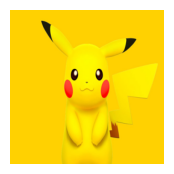

In [14]:
import requests
from PIL import Image

url = "https://cdn.vox-cdn.com/thumbor/PqAwdNpc7p-5GUCSMxQPehSU-ck=/0x0:1920x1200/1200x800/filters:focal(810x375:1116x681)/cdn.vox-cdn.com/uploads/chorus_image/image/72524797/pikachu_artwork.0.jpg"
pokemon_patch = np.array(
    Image.open(requests.get(url, stream=True).raw).resize((256, 256))
)
# Plotting the texture patch
plt.figure(figsize=(2, 2))
plt.imshow(pokemon_patch)
plt.axis("off")
plt.show()

In [15]:
pokemon_patch_tensor = transforms.ToTensor()(pokemon_patch).to("cuda")

In [16]:
adversarial_texture = torch.rand((3, 256, 256)).cuda()

In [17]:
adversarial_losses = AdvManholeLosses(
    adv_content_loss=adv_content_loss,
    mde_loss_weight=2.0,
    ss_ua_loss_weight=0.5,
    ss_ta_loss_weight=0.5,
    tv_loss_weight=1.0,
    content_loss_weight=0.25,
    background_loss_weight=0.0
)

In [18]:
import torch.optim as optim
from tqdm import tqdm

patch_texture_var = torch.nn.Parameter(pokemon_patch_tensor, requires_grad=True) # torch.nn.Parameter(adversarial_texture, requires_grad=True)

# Define the optimization pipeline
optimizer = optim.Adam([patch_texture_var], lr=0.01)

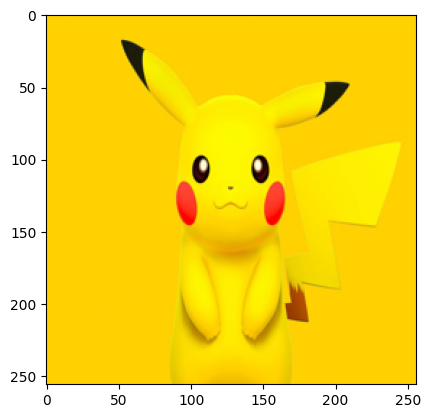

In [19]:
# Plot patch_texture_var
plt.imshow(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())
plt.show()


In [20]:
patch_texture_var.device

device(type='cuda', index=0)

In [21]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [22]:
# Create color jitter transform for data augmentation
texture_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]
)

output_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.1),
    ]
)

In [23]:
original_index = 0 # Road
# target_indices = list(range(1, 13))  # All classes except Road
target_indices = [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18]  # Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle

In [24]:
from collections import defaultdict
from PIL import Image

In [25]:
# class DepthTextureMapping:
#     def __init__(self, texture_res=256, tex_scale=0.5, tex_offset=[0.0, 0.0], random_scale=(0.0, 0.25), random_shift=(-0.4, 0.4), device=None):
#         self.texture_res = texture_res
#         self.tex_scale = tex_scale
#         self.tex_offset = tex_offset
#         self.random_scale = random_scale
#         self.random_shift = random_shift
        
#         if device is None:
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.device = device

#     def _get_texture_scale(self, batch_size: int):
#         tex_scales = (
#             torch.rand(batch_size) * (self.random_scale[1] - self.random_scale[0])
#             + self.random_scale[0]
#         ) + self.tex_scale

#         return tex_scales.to(self.device)
    
#     def _get_texture_offset(self, batch_size: int):
#         x_offset = (
#             torch.rand(batch_size) * (self.random_shift[1] - self.random_shift[0])
#             + self.random_shift[0]
#             + self.tex_offset[0]
#         ) 

#         y_offset = (
#             torch.rand(batch_size) * (self.random_shift[1] - self.random_shift[0])
#             + self.random_shift[0]
#             + self.tex_offset[1]
#             - (self.tex_scale * 0.5)  # Shift the offset to center the texture
#         )  

#         xyz_offsets = torch.stack([x_offset, y_offset, torch.zeros(batch_size)], dim=1)

#         return xyz_offsets.to(self.device)
    
#     def mapped_texture_mask(self, surface_xyz):
#         tex_scales = self._get_texture_scale(surface_xyz.shape[0])
#         xyz_offsets = self._get_texture_offset(surface_xyz.shape[0])

#         batch_image_size = [surface_xyz.shape[0], surface_xyz.shape[2], surface_xyz.shape[3]]

#         x_min = xyz_offsets[:, 0].view(-1, 1, 1).broadcast_to(*batch_image_size)
#         x_max = (xyz_offsets[:, 0] + tex_scales).view(-1, 1, 1).broadcast_to(*batch_image_size)
#         y_min = xyz_offsets[:, 1].view(-1, 1, 1).broadcast_to(*batch_image_size)
#         y_max = (xyz_offsets[:, 1] + tex_scales).view(-1, 1, 1).broadcast_to(*batch_image_size)

#         # Mask the centerized local coordinates given the texture size
#         texture_mask = torch.where(
#             (surface_xyz[:, 0] > x_min)
#             & (surface_xyz[:, 0] < x_max)
#             & (surface_xyz[:, 1] > y_min)
#             & (surface_xyz[:, 1] < y_max),
#             1.0,
#             0.0,
#         )

#         return texture_mask.unsqueeze(1) # Add channel dimension

#     # def depth_texture_mapping(self, textures, surface_xyz):
#     #     tex_scales = self._get_texture_scale(surface_xyz.shape[0])
#     #     xyz_offsets = self._get_texture_offset(surface_xyz.shape[0])

#     #     return torch.stack([
#     #         self._depth_texture_mapping(
#     #             textures[i],
#     #             surface_xyz[i],
#     #             tex_size=tex_scales[i],
#     #             tex_shift=xyz_offsets[i]
#     #         ) for i in range(surface_xyz.shape[0])
        
#     #     ])

       
#     # def _depth_texture_mapping(
#     #     self,
#     #     texture,
#     #     surface_xyz,
#     #     tex_size=1.0,
#     #     tex_shift=[0.0, 0.0, 0.0]
#     # ):
#     #     """
#     #     Maps a depth texture onto a surface based on UV coordinates.

#     #     Args:
#     #         texture (Tensor): The texture to be mapped onto the surface.
#     #         surface_xyz (Tensor): The surface coordinates of the object.
#     #         tex_size (float, optional): The size of the texture. Defaults to 1.0.
#     #         tex_shift (list[float], optional): The shift of the texture. Defaults to [0.0, 0.0, 0.0].
#     #         texture_res (int, optional): The resolution of the texture. Defaults to 256.

#     #     Returns:
#     #         Tensor: The rendered image with the texture mapped onto the surface.
#     #     """

#     #     # Convert to channel last
#     #     surface_xyz = surface_xyz.permute(1, 2, 0)
#     #     # normal_mask = normal_mask.permute(1, 2, 0)
#     #     texture_flat = texture.permute(1, 2, 0).view(-1, 3)
#     #     max_uv_idx = self.texture_res**2 - 1

#     #     # Get the UV coordinates by modulating the surface coordinates with the texture size
#     #     surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
#     #     surface_xyz_mod = surface_xyz_mod / tex_size

#     #     # Get the UV indices by multiplying the UV coordinates with the texture resolution
#     #     uv_idx = surface_xyz_mod * self.texture_res
#     #     uv_idx = torch.round(uv_idx).to(torch.int64)
#     #     uv_idx = torch.clamp(uv_idx, 0, self.texture_res - 1)

#     #     # Get the UV indices for each axis
#     #     uv_idx_z = uv_idx[..., [0, 1]]

#     #     # Invert the z uv indices
#     #     uv_idx_z[..., 0] = self.texture_res - uv_idx_z[..., 0]

#     #     # Get the UV indices for each axis flattened
#     #     uv_idx_z_flat = (uv_idx_z[..., 0] * self.texture_res + uv_idx_z[..., 1]).clamp_max(
#     #         max_uv_idx
#     #     )

#     #     # Get the rendered images for each axis
#     #     rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
#     #         surface_xyz_mod.shape
#     #     )

#     #     # Reverse the channel last to channel first
#     #     rendered_img_z = rendered_img_z.permute(2, 0, 1)

#     #     return rendered_img_z

#     def depth_texture_mapping(self, texture, surface_xyz):
#         """
#         Maps a depth texture onto a surface based on UV coordinates.

#         Args:
#             texture (Tensor): The texture to be mapped onto the surface.
#             surface_xyz (Tensor): The surface coordinates of the object.

#         Returns:
#             Tensor: The rendered image with the texture mapped onto the surface.
#         """
#         tex_scales = self._get_texture_scale(surface_xyz.shape[0])
#         xyz_offsets = self._get_texture_offset(surface_xyz.shape[0])

#         # Convert to channel last
#         surface_xyz = surface_xyz.permute(0, 2, 3, 1)
#         texture_flat = texture.permute(0, 2, 3, 1).reshape(-1, 3)
#         max_uv_idx = self.texture_res**2 - 1

#         xyz_offsets_broadcasted = xyz_offsets.view(-1, 1, 1, 3).broadcast_to(*surface_xyz.shape)
#         tex_scales_broadcasted = tex_scales.view(-1, 1, 1, 1).broadcast_to(*surface_xyz.shape)

#         print(surface_xyz.shape, xyz_offsets.shape, tex_scales_broadcasted.shape)

#         # Get the UV coordinates by modulating the surface coordinates with the texture size
#         surface_xyz_mod = (surface_xyz + xyz_offsets_broadcasted) % tex_scales_broadcasted # tex_scales.view(-1, 1, 1, 1)
#         surface_xyz_mod = surface_xyz_mod / tex_scales_broadcasted # tex_scales.view(-1, 1, 1, 1)

#         # Get the UV indices by multiplying the UV coordinates with the texture resolution
#         uv_idx = surface_xyz_mod * self.texture_res
#         uv_idx = torch.round(uv_idx).to(torch.int64)
#         uv_idx = torch.clamp(uv_idx, 0, self.texture_res - 1)

#         # Get the UV indices for each axis
#         uv_idx_z = uv_idx[..., [0, 1]]

#         # Invert the z uv indices
#         uv_idx_z[..., 0] = self.texture_res - uv_idx_z[..., 0]

#         # Get the UV indices for each axis flattened
#         uv_idx_z_flat = (uv_idx_z[..., 0] * self.texture_res + uv_idx_z[..., 1]).clamp_max(
#             max_uv_idx
#         )

#         # Get the rendered images for each axis
#         rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
#             surface_xyz_mod.shape
#         )

#         # Reverse the channel last to channel first
#         rendered_img_z = rendered_img_z.permute(0, 3, 1, 2)

#         return rendered_img_z

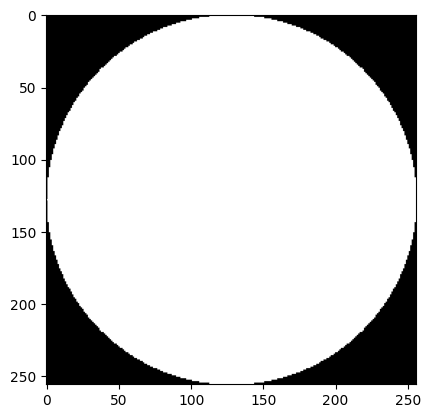

In [26]:
import numpy as np

def create_circle_mask(height, width, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(width/2), int(height/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], width-center[0], height-center[1])

    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

circle_mask = create_circle_mask(256, 256)

plt.imshow(circle_mask, cmap='gray')
plt.show()

print(circle_mask.shape)


In [27]:
from adv_manhole.texture_mapping.mapping import DepthTextureMapping

dtm_obj = DepthTextureMapping(device='cuda')

In [28]:
def mapped_texture_mask(
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
):
    """
    Generate a texture mask based on the given surface coordinates.

    Args:
        surface_xyz (torch.Tensor): The surface coordinates.
        tex_size (float, optional): The size of the texture. Defaults to 1.0.
        tex_shift (list[float], optional): The shift of the texture. Defaults to [0.0, 0.0, 0.0].

    Returns:
        torch.Tensor: The texture mask.
    """

    x_offset = tex_shift[0]
    y_offset = tex_shift[1]

    # Mask the centerized local coordinates given the texture size
    texture_mask = torch.where(
        (surface_xyz[0, ...] > x_offset)
        & (surface_xyz[0, ...] < x_offset + tex_size)
        & (surface_xyz[1, ...] > y_offset)
        & (surface_xyz[1, ...] < y_offset + tex_size),
        1.0,
        0.0,
    )

    return texture_mask


def depth_texture_mapping(
    texture,
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
    texture_res=256,
):
    """
    Maps a depth texture onto a surface based on UV coordinates.

    Args:
        texture (Tensor): The texture to be mapped onto the surface.
        surface_xyz (Tensor): The surface coordinates of the object.
        tex_size (float, optional): The size of the texture. Defaults to 1.0.
        tex_shift (list[float], optional): The shift of the texture. Defaults to [0.0, 0.0, 0.0].
        texture_res (int, optional): The resolution of the texture. Defaults to 256.

    Returns:
        Tensor: The rendered image with the texture mapped onto the surface.
    """

    # Convert to channel last
    surface_xyz = surface_xyz.permute(1, 2, 0)
    # normal_mask = normal_mask.permute(1, 2, 0)
    texture_flat = texture.permute(1, 2, 0).view(-1, 3)
    max_uv_idx = texture_res**2 - 1

    # Get the UV coordinates by modulating the surface coordinates with the texture size
    surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
    surface_xyz_mod = surface_xyz_mod / tex_size

    # Get the UV indices by multiplying the UV coordinates with the texture resolution
    uv_idx = surface_xyz_mod * texture_res
    uv_idx = torch.round(uv_idx).to(torch.int64)
    uv_idx = torch.clamp(uv_idx, 0, texture_res - 1)

    # Get the UV indices for each axis
    uv_idx_z = uv_idx[..., [0, 1]]

    # Invert the z uv indices
    uv_idx_z[..., 0] = texture_res - uv_idx_z[..., 0]

    # Get the UV indices for each axis flattened
    uv_idx_z_flat = (uv_idx_z[..., 0] * texture_res + uv_idx_z[..., 1]).clamp_max(
        max_uv_idx
    )

    # Get the rendered images for each axis
    rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
        surface_xyz_mod.shape
    )

    # Reverse the channel last to channel first
    rendered_img_z = rendered_img_z.permute(2, 0, 1)

    return rendered_img_z

In [29]:
patch_texture_var_circle = torch.cat(
    (patch_texture_var, torch.tensor(circle_mask).unsqueeze(0).float().cuda()))
print(patch_texture_var_circle.shape)

In [30]:
circle_mask_tensor = torch.tensor(circle_mask).unsqueeze(0).float().cuda()
circle_mask_tensor.shape

torch.Size([1, 256, 256])

In [44]:
# Train iteration
device = 'cuda'
with tqdm(
    data_iterable['train'], total=train_total_batch, desc=f"Train Epoch"
) as train_pbar:
    train_history = defaultdict(list)
    for batch in train_pbar:
        rgb = batch["rgb"].to(device)
        local_surface_coors = batch["local_surface_coors"].to(device)

        current_batch_size = rgb.shape[0]

        tex_scales = dtm_obj._get_texture_scale(current_batch_size)
        xyz_offsets = dtm_obj._get_texture_offset(current_batch_size)
         

        # # Repeat the texture to match the batch size
        batched_texture = patch_texture_var.unsqueeze(0).repeat(
            current_batch_size, 1, 1, 1
        )

        # Augment the texture with color jitter
        augmented_texture = torch.stack(
            [
                texture_augmentation(batched_texture[i])
                for i in range(current_batch_size)
            ]
        )

        circle_augmented_texture = torch.cat(
            (augmented_texture, circle_mask_tensor.unsqueeze(0).repeat(current_batch_size, 1, 1, 1)), 
        dim=1)

        texture_masks = dtm_obj.mapped_texture_mask(local_surface_coors, tex_scales, xyz_offsets)

        texture_mapped_images = dtm_obj.depth_texture_mapping(circle_augmented_texture, local_surface_coors, tex_scales, xyz_offsets)

        projected_texture, alpha_channel = texture_mapped_images[:, :3, ...], texture_mapped_images[:, -1:, ...]

        texture_masks = texture_masks.repeat(1, 3, 1, 1) * alpha_channel.repeat(1, 3, 1, 1)
        
        final_images = projected_texture * texture_masks + rgb * (1.0 - texture_masks)

        break

Train Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([524288, 4])
torch.Size([8, 720, 1280, 3]) torch.Size([8, 3]) torch.Size([8, 720, 1280, 3])


Train Epoch:   0%|          | 0/200 [00:01<?, ?it/s]


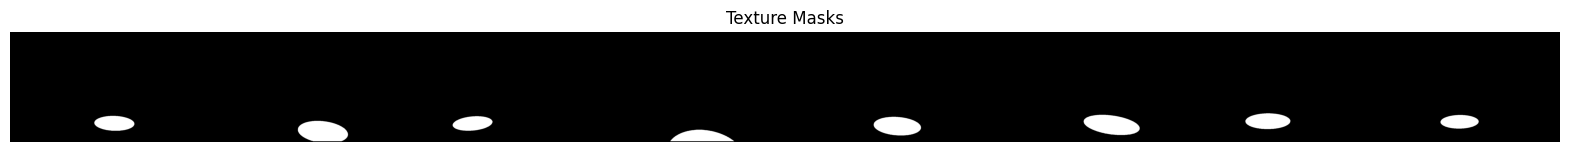

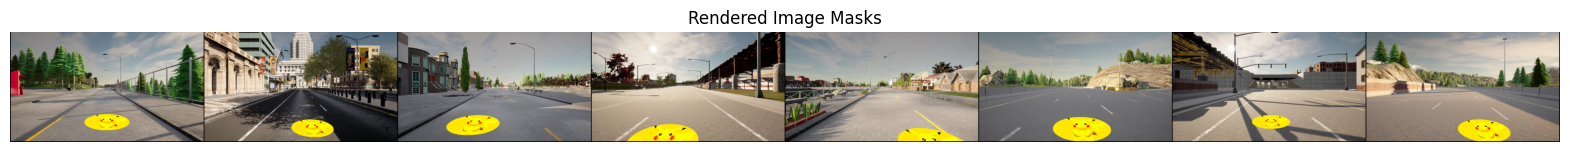

In [45]:
# Plot the texture mask for the first batch (8 images)
plt.figure(figsize=(20, 5))
plt.imshow(
    np.transpose(
        make_grid(circled_texture_masks, nrow=8, padding=5).cpu(),
        (1, 2, 0),
    )
)
plt.title("Texture Masks")
plt.axis("off")
plt.show()

# Plot the texture mask for the first batch (8 images)
plt.figure(figsize=(20, 5))
plt.imshow(
    np.transpose(
        make_grid(final_images, nrow=8, padding=5).cpu(),
        (1, 2, 0),
    )
)
plt.title("Rendered Image Masks")
plt.axis("off")
plt.show()


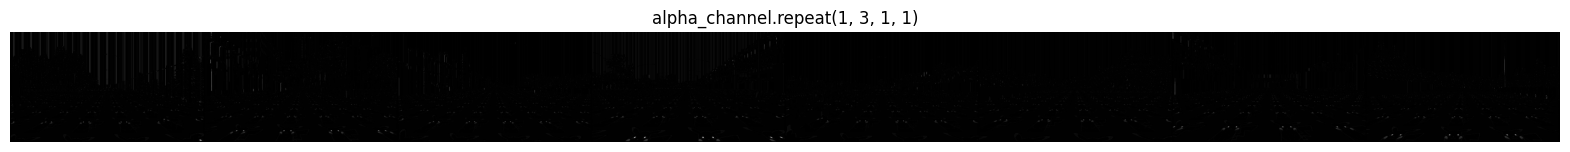

In [51]:
# Plot the texture mask for the first batch (8 images)
plt.figure(figsize=(20, 5))
plt.imshow(
    np.transpose(
        make_grid(alpha_channel.repeat(1, 3, 1, 1), nrow=8, padding=5).cpu(),
        (1, 2, 0),
    )
)
plt.title("alpha_channel.repeat(1, 3, 1, 1)")
plt.axis("off")
plt.show()

In [23]:
output_path = "/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_center"
os.makedirs(output_path, exist_ok=True)

In [25]:
def forward(batch, patch_texture_var, tex_rand_size, tex_rand_shift_x, tex_rand_shift_y, device):
    rgb = batch["rgb"].to(device)
    local_surface_coors = batch["local_surface_coors"].to(device)

    current_batch_size = rgb.shape[0]

    # Generate random texture size with shape [batch_size] ranging from [min_size, max_size]
    tex_size = (
        torch.rand(current_batch_size) * (tex_rand_size[1] - tex_rand_size[0])
        + tex_rand_size[0]
    ).to(device)

    # Generate random texture shift with shape [batch_size, 2] ranging from [min_shift, max_shift]
    tex_shift_x = (
        torch.rand(current_batch_size, 1) * (tex_rand_shift_x[1] - tex_rand_shift_x[0])
        + tex_rand_shift_x[0]
    )

    tex_shift_y = (
        torch.rand(current_batch_size, 1) * (tex_rand_shift_y[1] - tex_rand_shift_y[0])
        + tex_rand_shift_y[0]
    )

    # Add zeros to texture shift z axis
    tex_shift = torch.cat(
        [tex_shift_x, tex_shift_y, torch.zeros(current_batch_size, 1)], dim=1
    ).to(device)

    # Shift the offset to center the texture
    tex_shift[:, 1] -= tex_size * 0.5

    # Generate texture masks. TODO: Vectorize this operation
    texture_masks = torch.stack(
        [
            mapped_texture_mask(
                local_surface_coors[i],
                tex_size=tex_size[i],
                tex_shift=tex_shift[i],
            )
            for i in range(current_batch_size)
        ]
    ).unsqueeze(1) # Add channel dimension

    # Repeat the texture to match the batch size
    batched_texture = patch_texture_var.unsqueeze(0).repeat(
        current_batch_size, 1, 1, 1
    )

    # Augment the texture with color jitter
    augmented_texture = torch.stack(
        [
            texture_augmentation(batched_texture[i])
            for i in range(current_batch_size)
        ]
    )

    # Generate the texture mapping
    texture_mapped_images = torch.stack(
        [
            depth_texture_mapping(
                augmented_texture[i],
                local_surface_coors[i],
                tex_size=tex_size[i],
                tex_shift=tex_shift[i],
            )
            for i in range(current_batch_size)
        ]
    )

    # Apply the texture mask to the texture mapped images
    final_images = texture_mapped_images * texture_masks + rgb * (1.0 - texture_masks)

    # Apply the output augmentation
    augmented_final_images = torch.stack(
        [
            output_augmentation(final_images[i])
            for i in range(current_batch_size)
        ]
    )

    # Predict the depth and semantic segmentation
    predicted_disp = monodepth2_model(final_images) #augmented_final_images)
    predicted_semantic = ddrnet_model(augmented_final_images)

    # Calculate tv loss
    tv_loss = adversarial_losses.tv_loss(patch_texture_var)

    # Calculte background loss
    background_loss = adversarial_losses.background_loss(
        final_images, rgb, texture_masks.repeat(1, 3, 1, 1)
    )

    # Calculate mde loss
    mde_loss = adversarial_losses.adversarial_mde_loss(
        predicted_disp,
        torch.ones_like(predicted_disp),
        texture_masks,
    )

    # Calculate ss
    ss_ua_loss, ss_ta_loss = adversarial_losses.adversarial_ss_loss(
        predicted_semantic,
        original_index=original_index,
        target_indices=target_indices,
        masks=texture_masks,
    )

    # Calculate content loss
    content_loss, min_content_idx = adversarial_losses.adversarial_content_loss(
        patch_texture_var
    )

    # Calculate the total loss
    total_loss = (
        mde_loss + ss_ua_loss + ss_ta_loss + tv_loss + content_loss + background_loss 
    )

    return {
        "total_loss": total_loss,
        "mde_loss": mde_loss,
        "ss_ua_loss": ss_ua_loss,
        "ss_ta_loss": ss_ta_loss,
        "tv_loss": tv_loss,
        "content_loss": content_loss,
        "background_loss": background_loss,
        "min_content_idx": min_content_idx,
        "predicted_disp": predicted_disp,
        "predicted_semantic": predicted_semantic,
        "final_images": final_images,
        "augmented_final_images": augmented_final_images,
        "texture_masks": texture_masks,
        "tex_size": tex_size,
        "tex_shift": tex_shift,
    }

In [27]:
# Wandb setup
import wandb

run = wandb.init(
    project="adversarial-manhole",
    entity="naufalso",
    name="near_patch_targeted_center_poc_full_center",
    config={
        "mde_model": "mono_640x192",
        "ss_model": "ddrnet_23",
        "texture_size": 0.5,
        "rand_texture_shift_x": [0.0, 0.01],
        "rand_texture_shift_y": [-0.01, 0.01],
        "rand_texture_size": [0.5, 0.51],
        "texture_res": 256,
        "mde_loss_weight": 2.0,
        "ss_ua_loss_weight": 0.5,
        "ss_ta_loss_weight": 0.5,
        "tv_loss_weight": 1.0,
        "content_loss_weight": 0.05,
        "background_loss_weight": 0.0,
        "lr": 0.01,
        "batch_size": 8,
        "epochs": 100,
        "texture_augmentation": {
            "brightness": 0.2,
            "contrast": 0.1,
        },
        "output_augmentation": {
            "brightness": 0.2,
            "contrast": 0.1,
        },
    }
)

epochs = 20
tex_min_size, tex_max_size = 0.5, 0.51  # 0.5, 0.75
tex_min_shift_x, tex_max_shift_x = 0.0, 0.01  
tex_min_shift_y, tex_max_shift_y = -0.01, 0.01 # -0.4, 0.4

[2024-05-30 09:44:57] ERROR - jupyter.py - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naufalso. Use `wandb login --relogin` to force relogin


In [28]:
epochs = 50

In [29]:
run.config.epochs=50

In [30]:
log_prediction_every = 5

In [31]:
import random

In [32]:
train_epoch_history = defaultdict(list)
val_epoch_history = defaultdict(list)

for epoch in range(epochs):
    # Train iteration
    with tqdm(
        data_iterable['train'], total=train_total_batch, desc=f"Train Epoch {epoch + 1}/{epochs}"
    ) as train_pbar:
        train_history = defaultdict(list)
        for batch in train_pbar:
            optimizer.zero_grad()

            results = forward(batch, patch_texture_var, (tex_min_size, tex_max_size), (tex_min_shift_x, tex_max_shift_x), (tex_min_shift_y, tex_max_shift_y), device="cuda")

            # Backpropagate the loss
            results["total_loss"].backward()
            optimizer.step()

            # Clip the texture to [0, 1]
            patch_texture_var.data.clamp_(0, 1)

            # Update the progress bar
            train_pbar.set_postfix(
                {
                    key: value.item()
                    for key, value in results.items()
                    if 'loss' in key
                }
            )

            # Update the train history
            for key, value in results.items():
                if 'loss' in key:
                    train_history[key].append(value.item())

        for key, value in train_history.items():
            mean_value = np.mean(value)
            train_epoch_history[key].append(mean_value)
            run.log({f"train/{key}": mean_value}, commit=False)

        # Save the texture as image
        Image.fromarray((patch_texture_var.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)).save(
            os.path.join(output_path, f"texture_epoch_{epoch}.png")
        )

    # Validation iteration
    with tqdm(
        data_iterable['validation'], total=val_total_batch, desc=f"Validation {epoch + 1}/{epochs}"
    ) as val_pbar:
        val_history = defaultdict(list)
        for batch in val_pbar:
            with torch.no_grad():
                results = forward(batch, patch_texture_var, (tex_min_size, tex_max_size), (tex_min_shift_x, tex_max_shift_x), (tex_min_shift_y, tex_max_shift_y), device="cuda")

            # Update the progress bar
            val_pbar.set_postfix(
                {
                    key: value.item()
                    for key, value in results.items()
                    if 'loss' in key
                }
            )

            # Update the validation history
            for key, value in results.items():
                if 'loss' in key:
                    val_history[key].append(value.item())

        for key, value in val_history.items():
            mean_value = np.mean(value)
            val_epoch_history[key].append(mean_value)
            run.log({f"val/{key}": mean_value}, commit=False)

    # Log the visualizations
    if epoch % log_prediction_every == 0:
        augmented_final_images = results["augmented_final_images"]
        predicted_disp = results["predicted_disp"]
        predicted_semantic = results["predicted_semantic"]

        random_idx = random.randint(0, augmented_final_images.shape[0] - 1)

        disp_pred_fig = monodepth2_model.plot(
            augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
            predicted_disp[random_idx],
        )

        semantic_pred_fig = ddrnet_model.plot(
            augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
            predicted_semantic[random_idx],
        )

        run.log(
            {
                "val/disp_pred": disp_pred_fig,
                "val/semantic_pred": semantic_pred_fig,
            },
            commit=False
        )

    # Log the texture to wandb
    run.log({"texture": wandb.Image(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())})


Train Epoch 1/50:   0%|          | 0/200 [00:00<?, ?it/s]/home/carla_client/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Validation 50/50: 100%|██████████| 67/67 [02:31<00:00,  2.26s/it, total_loss=0.233, mde_loss=0.0142, ss_ua_loss=0.00397, ss_ta_loss=0.0172, tv_loss=0.0822, content_loss=0.115, background_loss=0] 


In [33]:
run.finish()

train/background_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/content_loss,█▅▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mde_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ss_ta_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ss_ua_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/tv_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/background_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/content_loss,█▄▃▃▂▂▂▂▁▂▁▂▂▂▁▂▁▂▂▂▁▂▁▂▁▁▂▁▁▁▁▂▂▂▂▂▁▂▂▁
val/mde_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/ss_ta_loss,█▃▃▃▂▁▁▂▁▁▁▂▁▂▁▂▁▂▃▄▁▂▁▂▁▁▃▁▁▁▂▃▃▂▂▂▁▂▃▂


In [19]:
# # Try to overfit to check if the optimization is working
# with tqdm(range(1000), total=1000) as train_pbar:
#     for i in train_pbar:
#         optimizer.zero_grad()

#         rgb = batch["rgb"]
#         local_surface_coors = batch["local_surface_coors"]

#         current_batch_size = rgb.shape[0]

#         # Generate random texture size with shape [batch_size] ranging from [min_size, max_size]
#         tex_size = (
#             torch.rand(current_batch_size) * (tex_max_size - tex_min_size)
#             + tex_min_size
#         )

#         # Generate random texture shift with shape [batch_size, 2] ranging from [min_shift, max_shift]
#         tex_shift = (
#             torch.rand(current_batch_size, 2) * (tex_max_shift - tex_min_shift)
#             + tex_min_shift
#         )

#         # Add zeros to texture shift z axis
#         tex_shift = torch.cat(
#             [tex_shift, torch.zeros(current_batch_size, 1)], dim=1
#         )

#         # Shift the offset to center the texture
#         tex_shift[:, 1] -= tex_size * 0.5

#         # Generate texture masks. TODO: Vectorize this operation
#         texture_masks = torch.stack(
#             [
#                 mapped_texture_mask(
#                     local_surface_coors[i],
#                     tex_size=tex_size[i],
#                     tex_shift=tex_shift[i],
#                 )
#                 for i in range(current_batch_size)
#             ]
#         ).unsqueeze(1) # Add channel dimension

#         # Repeat the texture to match the batch size
#         batched_texture = patch_texture_var.unsqueeze(0).repeat(
#             current_batch_size, 1, 1, 1
#         )

#         # Augment the texture with color jitter
#         augmented_texture = torch.stack(
#             [
#                 texture_augmentation(batched_texture[i])
#                 for i in range(current_batch_size)
#             ]
#         )

#         # Generate the texture mapping
#         texture_mapped_images = torch.stack(
#             [
#                 depth_texture_mapping(
#                     augmented_texture[i],
#                     local_surface_coors[i],
#                     tex_size=tex_size[i],
#                     tex_shift=tex_shift[i],
#                 )
#                 for i in range(current_batch_size)
#             ]
#         )

#         # Apply the texture mask to the texture mapped images
#         final_images = texture_mapped_images * texture_masks + rgb * (1.0 - texture_masks)

#         # Apply the output augmentation
#         augmented_final_images = torch.stack(
#             [
#                 output_augmentation(final_images[i])
#                 for i in range(current_batch_size)
#             ]
#         )

#         # Predict the depth and semantic segmentation
#         predicted_disp = monodepth2_model(augmented_final_images)
#         predicted_semantic = ddrnet_model(augmented_final_images)

#         # Calculate tv loss
#         tv_loss = adversarial_losses.tv_loss(patch_texture_var)

#         # Calculte background loss
#         background_loss = adversarial_losses.background_loss(
#             final_images, rgb, texture_masks.repeat(1, 3, 1, 1)
#         )

#         # Calculate mde loss
#         mde_loss = adversarial_losses.adversarial_mde_loss(
#             predicted_disp,
#             torch.zeros_like(predicted_disp),
#             texture_masks,
#         )

#         # # Calculate ss
#         ss_ua_loss, ss_ta_loss = adversarial_losses.adversarial_ss_loss(
#             predicted_semantic,
#             original_index=original_index,
#             target_indices=target_indices,
#             masks=texture_masks,
#         )

#         # Calculate the total loss
#         total_loss = (
#             mde_loss + ss_ua_loss + ss_ta_loss + tv_loss + background_loss
#         )

#         # Backpropagate the loss
#         total_loss.backward()
#         optimizer.step()

#         # Clip the texture to [0, 1]
#         patch_texture_var.data.clamp_(0, 1)

#         # Update the progress bar
#         train_pbar.set_postfix(
#             {
#                 "MDE Loss": mde_loss.item(),
#                 "SS UA Loss": ss_ua_loss.item(),
#                 "SS TA Loss": ss_ta_loss.item(),
#                 "TV Loss": tv_loss.item(),
#                 "Background Loss": background_loss.item(),
#                 "Total Loss": total_loss.item(),
#             }
#         )

  2%|▏         | 16/1000 [00:23<24:23,  1.49s/it, MDE Loss=0.634, SS UA Loss=0.0448, SS TA Loss=0.0706, TV Loss=0.0773, Background Loss=0.0285, Total Loss=0.855]

In [30]:
augmented_final_images = results["augmented_final_images"]
predicted_disp = results["predicted_disp"]
predicted_semantic = results["predicted_semantic"]

random_idx = random.randint(0, augmented_final_images.shape[0] - 1)

disp_pred_fig = monodepth2_model.plot(
    augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
    predicted_disp[random_idx],
)

semantic_pred_fig = ddrnet_model.plot(
    augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
    predicted_semantic[random_idx],
)

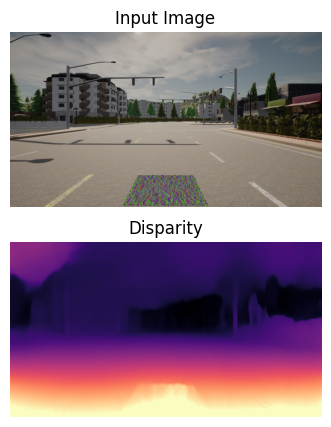

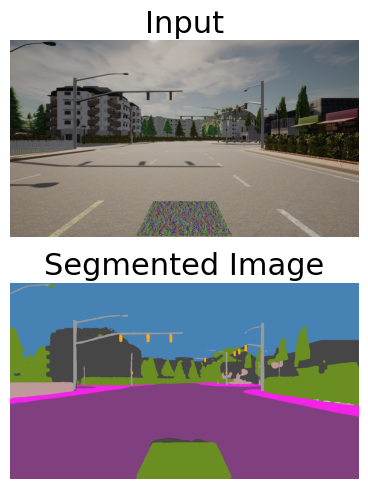

In [32]:
plt.show()

In [24]:
# Plot mde
fig = monodepth2_model.plot(
    image=final_images[0].permute(1, 2, 0).detach().cpu().numpy(),
    prediction=predicted_disp[0].detach(),
)
plt.show()

# Plot ss
fig = ddrnet_model.plot(
    image=final_images[0].permute(1, 2, 0).detach().cpu().numpy(),
    prediction=predicted_semantic[0].detach(),
)
plt.show()

# Plot mask
plt.imshow(final_images[0].permute(1, 2, 0).detach().cpu().numpy())
plt.imshow(texture_masks[0].detach().squeeze(0).cpu().numpy(), alpha=0.5)
plt.show()

plt.imshow(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

NameError: name 'final_images' is not defined

In [31]:
valid_depth = predicted_disp[texture_masks  >0.5]
valid_depth.shape

torch.Size([307559])

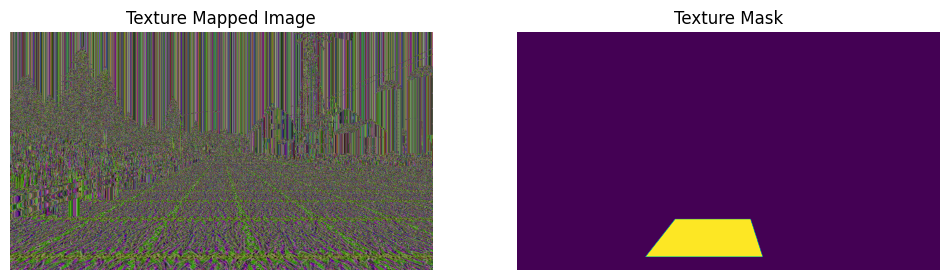

In [22]:
# Plot texture_mapped_images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(texture_mapped_images.detach().cpu()[0].permute(1, 2, 0).numpy())
plt.title("Texture Mapped Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(texture_masks[0].detach().squeeze().cpu().numpy())
plt.title("Texture Mask")
plt.axis("off")
plt.show()

In [27]:
texture_mapped_images.shape

torch.Size([8, 3, 720, 1280])